In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import sys
sys.path.append("../")
from UpStraight_Train import training_columns

In [27]:
# get training data
data = pd.read_csv('../data/train.csv').dropna()
data["posture"] = data["posture"].map({-1:0,0:0,1:1})

### Adding MetaData to training Data

In [28]:
# read metadata from metadata.json as a dict
metadata = pd.read_json('../data/metadata.json', orient='index').to_dict(orient='index')["metadata"]
metadata

{'lass': {'id': 'lass',
  'gender': '0',
  'firstName': None,
  'lastName': None,
  'dateOfBirth': '1999-03-26 16:27:23 +0000',
  'height': '189',
  'weight': '82',
  'activity': '2'},
 'far': {'id': 'far',
  'gender': '0',
  'firstName': None,
  'lastName': None,
  'dateOfBirth': '1965-09-22 16:27:23 +0000',
  'height': '186',
  'weight': '76',
  'activity': '1'},
 'cr': {'id': 'cr',
  'gender': '0',
  'firstName': None,
  'lastName': None,
  'dateOfBirth': '2000-01-04 16:27:23 +0000',
  'height': '181',
  'weight': '71',
  'activity': '1'},
 'as': {'id': 'as',
  'gender': '0',
  'firstName': None,
  'lastName': None,
  'dateOfBirth': '2000-04-26 16:27:23 +0000',
  'height': '176',
  'weight': '70',
  'activity': '2'},
 'dotz': {'id': 'dotz',
  'gender': '1',
  'firstName': None,
  'lastName': None,
  'dateOfBirth': '2004-06-19 16:27:23 +0000',
  'height': '165',
  'weight': '57',
  'activity': '2'}}

In [29]:
# add each entry in metadata as a row in new dataframe
metadata_df = pd.DataFrame(metadata).transpose().rename(columns={"id":"source"})
# make height and weight numeric
metadata_df["height"] = pd.to_numeric(metadata_df["height"], errors='coerce')
metadata_df["weight"] = pd.to_numeric(metadata_df["weight"], errors='coerce')
# set gender to integer (equivalent to one hot encoding here)
metadata_df["gender"] = metadata_df["gender"].astype(int)

In [30]:
data_md = pd.merge(data, metadata_df, on="source", how="left")

In [31]:
# add age column to training_columns by taking difference between dateOfBirth and today in years
data_md["age"] = round((pd.to_datetime("today") - pd.to_datetime(data_md["dateOfBirth"]).dt.tz_localize(None)).dt.days / 365.25)

### Train a simple (CVGrid optimized) RandomForest

In [34]:
y = data_md["posture"]
X = data_md[training_columns + ["age","gender","height","weight"]] # leave out activity for now
# one hot encode gender and activity
param_grid = {"max_depth": [3,4,5,7,9,12],"n_estimators": [10,20,30,40,50,100]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search_results = grid_search.fit(X, y) 


Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [35]:
pd.DataFrame(grid_search_results.cv_results_).sort_values(by="rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.013178,0.001885,0.001359,0.000171,3,20,"{'max_depth': 3, 'n_estimators': 20}",0.676923,0.600000,0.584615,0.718750,0.515625,0.619183,0.071463,1
10,0.034174,0.005739,0.001697,0.000103,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.584615,0.584615,0.600000,0.656250,0.515625,0.588221,0.044862,2
8,0.018746,0.003123,0.001733,0.000926,4,30,"{'max_depth': 4, 'n_estimators': 30}",0.523077,0.569231,0.584615,0.640625,0.593750,0.582260,0.037991,3


In [36]:
best = grid_search_results.best_estimator_
preds = best.predict(X)

The model does not really consider the metadata at all. It also doesnt really use ApplestandTime:

In [37]:
pd.DataFrame({"feature": best.feature_names_in_, "importance": best.feature_importances_}).sort_values(by="importance", ascending=False)

,feature,importance
8,ActiveEnergyBurned_15_min,0.132073
20,HeartRate_30_std,0.099675
17,HeartRate_30_mean,0.073433
7,ActiveEnergyBurned_15_max,0.067340
4,HeartRate_15_std,0.048264
6,ActiveEnergyBurned_15_mean,0.048170
1,HeartRate_15_mean,0.047298
23,ActiveEnergyBurned_30_max,0.043354
19,HeartRate_30_min,0.037691
0,hour,0.033766


General Results are plagued by poor recall:

<AxesSubplot:>

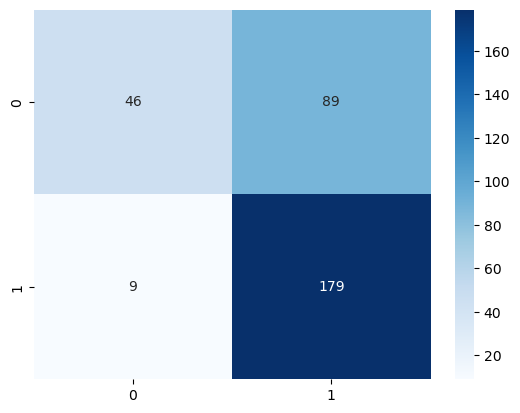

In [38]:
from seaborn import heatmap as sns_heatmap
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

sns_heatmap(confusion_matrix(y, preds), annot=True, fmt="d", cmap="Blues")

In [39]:
print(roc_auc_score(y, preds))
print(classification_report(y, preds))

0.6464342001576044
              precision    recall  f1-score   support

           0       0.84      0.34      0.48       135
           1       0.67      0.95      0.79       188

    accuracy                           0.70       323
   macro avg       0.75      0.65      0.63       323
weighted avg       0.74      0.70      0.66       323



In [40]:
# conditional on sitting
sitting_mask = data_md[data_md["state_string"] == "Sitting"].index
print(roc_auc_score(y[sitting_mask], preds[sitting_mask]))
print(classification_report(y[sitting_mask], preds[sitting_mask]))

0.5967534849596479
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        29
           1       0.89      0.95      0.92       188

    accuracy                           0.86       217
   macro avg       0.66      0.60      0.62       217
weighted avg       0.83      0.86      0.84       217



<AxesSubplot:>

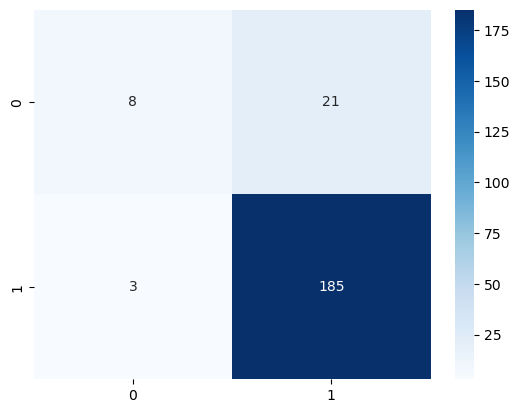

In [57]:
sns_heatmap(confusion_matrix(y[sitting_mask], preds[sitting_mask]), annot=True, fmt="d", cmap="Blues")

In [75]:
# conditional on NOT sitting
not_sitting_mask = data_md[data_md["state_string"] != "Sitting"].index
# roc auc not defined if empty class...
print(classification_report(y[not_sitting_mask], preds[not_sitting_mask]))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59       106
           1       0.00      0.00      0.00         0

    accuracy                           0.42       106
   macro avg       0.50      0.21      0.29       106
weighted avg       1.00      0.42      0.59       106



/Users/lasse/miniconda3/envs/upstraight/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lasse/miniconda3/envs/upstraight/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lasse/miniconda3/envs/upstraight/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

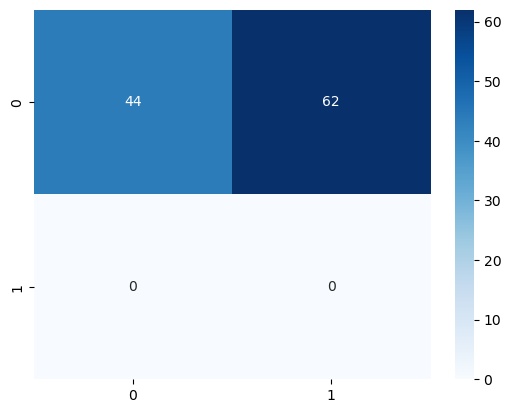

In [61]:
sns_heatmap(confusion_matrix(y[not_sitting_mask], preds[not_sitting_mask]), annot=True, fmt="d", cmap="Blues")

In [76]:
# conditional on source being "lass"
lass_mask = data_md[data_md["source"] == "lass"].index
print(roc_auc_score(y[lass_mask], preds[lass_mask]))
print(classification_report(y[lass_mask], preds[lass_mask]))

0.7166666666666667
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        30
           1       0.76      1.00      0.86        54

    accuracy                           0.80        84
   macro avg       0.88      0.72      0.73        84
weighted avg       0.85      0.80      0.77        84



<AxesSubplot:>

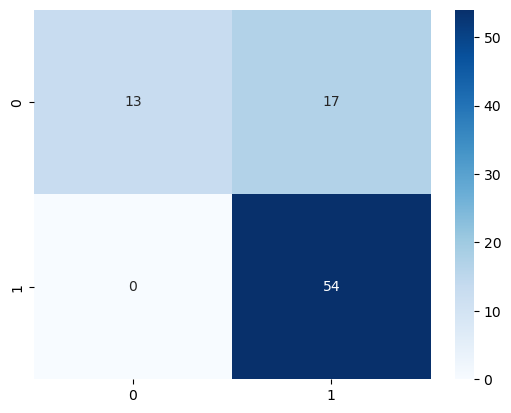

In [64]:
sns_heatmap(confusion_matrix(y[lass_mask], preds[lass_mask]), annot=True, fmt="d", cmap="Blues")

In [77]:
# conditional on being "lass" and sitting
lass_sitting_mask = data_md[(data_md["source"] == "lass") & (data_md["state_string"] == "Sitting")].index
print(roc_auc_score(y[lass_sitting_mask], preds[lass_sitting_mask]))
print(classification_report(y[lass_sitting_mask], preds[lass_sitting_mask]))

0.625
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.95      1.00      0.97        54

    accuracy                           0.95        58
   macro avg       0.97      0.62      0.69        58
weighted avg       0.95      0.95      0.93        58



<AxesSubplot:>

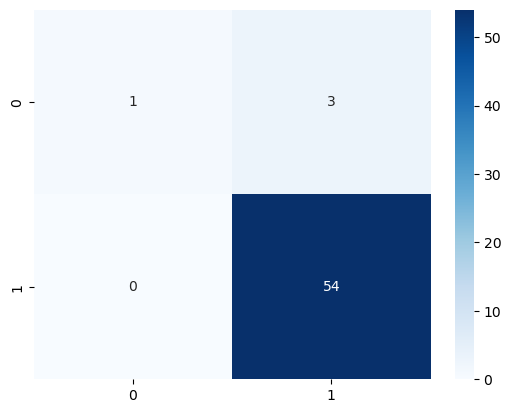

In [66]:
sns_heatmap(confusion_matrix(y[lass_sitting_mask], preds[lass_sitting_mask]), annot=True, fmt="d", cmap="Blues")

In [78]:
# for cr only
cr_mask = data_md[data_md["source"] == "cr"].index
print(roc_auc_score(y[cr_mask], preds[cr_mask]))
print(classification_report(y[cr_mask], preds[cr_mask]))

0.6590909090909092
              precision    recall  f1-score   support

           0       1.00      0.32      0.48        44
           1       0.62      1.00      0.77        49

    accuracy                           0.68        93
   macro avg       0.81      0.66      0.62        93
weighted avg       0.80      0.68      0.63        93



<AxesSubplot:>

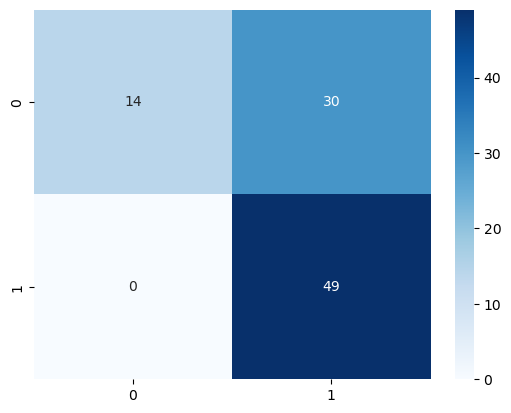

In [79]:
sns_heatmap(confusion_matrix(y[cr_mask], preds[cr_mask]), annot=True, fmt="d", cmap="Blues")

The general model performs worse than the model trained with individual weights (not surprising).
In the data there is an imbalance towards slouched data points, so the model tends to overclassify as slouched. Interestingly, many non-sitting data points are classified as slouched, which in our DGP is impossible. When conditioning on sitting, performance goes up, surprisingly, since we get rid of all these missclassifications and end up with a high precision, low recall scenario which due to the high imbalance puts accuracy still at 90%.

### Train a Neural Net on Raw Data

In [60]:
import tensorflow as tf

print(tf.__version__)

2.11.0


In [61]:
nn_data = data_md[training_columns + ["age","gender","height","weight", "activity", "posture"]] # keep posture in here 
nn_data

,hour,HeartRate_15_mean,HeartRate_15_max,HeartRate_15_min,HeartRate_15_std,HeartRate_15_range,ActiveEnergyBurned_15_mean,ActiveEnergyBurned_15_max,ActiveEnergyBurned_15_min,ActiveEnergyBurned_15_std,...,AppleStandTime_30_min,AppleStandTime_30_range,HeartRate_30_ar1_coef,ActiveEnergyBurned_30_ar1_coef,age,gender,height,weight,activity,posture
0,19,84.000000,89.0,79.0000,5.000000,10.0000,0.214231,0.366,0.017,0.113776,...,0.0,1.0,0.579167,0.195443,24.0,0,181,71,1,0
1,17,82.333333,84.0,80.0000,2.081666,4.0000,0.280286,0.421,0.061,0.100903,...,0.0,0.0,1.142857,0.442224,24.0,0,181,71,1,1
2,16,79.500000,88.0,75.0000,6.137318,13.0000,0.440538,1.457,0.014,0.452358,...,0.0,3.0,0.347584,0.456471,24.0,0,181,71,1,0
3,15,77.000000,78.0,76.0000,1.000000,2.0000,0.227385,0.366,0.029,0.119166,...,0.0,0.0,-0.181818,0.136979,24.0,0,181,71,1,1
4,15,74.000000,76.0,72.0000,2.828427,4.0000,0.193692,0.403,0.017,0.128122,...,0.0,0.0,-0.774566,0.193813,24.0,0,181,71,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,12,56.000000,57.0,55.0000,1.000000,2.0000,0.361154,0.905,0.062,0.220816,...,0.0,0.0,1.045455,0.078609,58.0,0,186,76,1,0
319,11,53.333333,54.0,52.0000,1.154701,2.0000,0.263636,0.448,0.084,0.122292,...,0.0,1.0,-0.617647,0.228424,58.0,0,186,76,1,0
320,11,54.250000,57.0,52.0000,2.217356,5.0000,0.387000,0.818,0.109,0.206108,...,0.0,1.0,-0.007876,0.675327,58.0,0,186,76,1,1
321,9,62.367150,65.0,60.4686,2.066074,4.5314,0.259786,0.564,0.047,0.144392,...,0.0,2.0,1.557110,0.445845,58.0,0,186,76,1,0


In [62]:
# create validation set (random 20% of data) using numpy
import numpy as np
msk = (np.random.rand(len(nn_data)) < 0.8)
nn_train = nn_data[msk]
nn_val = nn_data[~msk]

In [63]:
from tensorflow.keras import layers

# function that builds tf dataset from dataframe
def df_to_dataset(dataframe, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('posture')
    df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

batch_size = 5
train_ds = df_to_dataset(nn_train.iloc[:,-4:], batch_size=batch_size)
[(train_features, label_batch)] = train_ds.take(1)
print(train_features)

{'height': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[181],
       [181],
       [181],
       [181],
       [181]])>, 'weight': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[71],
       [71],
       [71],
       [71],
       [71]])>, 'activity': <tf.Tensor: shape=(5, 1), dtype=string, numpy=
array([[b'1'],
       [b'1'],
       [b'1'],
       [b'1'],
       [b'1']], dtype=object)>, 'posture': <tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[0],
       [1],
       [0],
       [1],
       [0]])>}


/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_6686/109507841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}


In [64]:
# function that adds a CategoryEncoding layer for "activity"
def get_category_encoding_layer(name, dataset, dtype):
    if dtype == 'string':
        index = layers.StringLookup()
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup()

    features_ds = dataset.map(lambda x, y: x[name])
    index.adapt(features_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

test_type_col = train_features["activity"]
test_type_layer = get_category_encoding_layer("activity", train_ds, dtype = "string") #dtype Int
test_type_layer(test_type_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-09-27 12:03:38.359798: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)>

In [65]:
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization()
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer    


ht_15_mean = train_features["HeartRate_15_mean"]
layer = get_normalization_layer("HeartRate_15_mean", train_ds)
layer(ht_15_mean)

KeyError: 'HeartRate_15_mean'

In [67]:
# preprocess our selection of features:
all_features = nn_train.columns.to_list()[:-1] # leave out posture
categorical_features = all_features.pop(-1) # activity
numerical_features = all_features

In [78]:
batch_size = 100
train_ds = df_to_dataset(nn_train, batch_size=batch_size)
val_ds = df_to_dataset(nn_val, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numeric features.
for header in numerical_features:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

# Categorical features encoded as strings ("activity")
activity_col = tf.keras.Input(shape=(1,), name="activity", dtype="string")
encoding_layer = get_category_encoding_layer("activity", train_ds, dtype="string")
encoded_activity_col = encoding_layer(activity_col)
all_inputs.append(activity_col)
encoded_features.append(encoded_activity_col)


/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_82729/109507841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}
/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_82729/109507841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}


In [82]:
# create, compile and train the model
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)


In [89]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[callback])

Epoch 1/20
3/3 [==============================] - 0s 7ms/step - loss: 0.6434 - accuracy: 0.5985 - val_loss: 0.7652 - val_accuracy: 0.4531
Epoch 2/20
3/3 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5444 - val_loss: 0.7637 - val_accuracy: 0.4375
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.6816 - accuracy: 0.5714 - val_loss: 0.7630 - val_accuracy: 0.4375
Epoch 4/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6756 - accuracy: 0.5483 - val_loss: 0.7611 - val_accuracy: 0.4219
Epoch 5/20
3/3 [==============================] - 0s 7ms/step - loss: 0.6446 - accuracy: 0.5598 - val_loss: 0.7575 - val_accuracy: 0.4219


In [88]:
history.history["loss"]

[0.8101400136947632,
 0.7868034839630127,
 0.7245426774024963,
 0.7520821690559387,
 0.7643103003501892,
 0.7599539756774902,
 0.7229204177856445,
 0.713982343673706,
 0.7841185331344604,
 0.7161809802055359,
 0.7458241581916809,
 0.7095054984092712,
 0.7039797306060791,
 0.7455894351005554,
 0.7140156626701355,
 0.664199709892273,
 0.7145289778709412,
 0.6164607405662537,
 0.6792212724685669,
 0.6966743469238281,
 0.7090566754341125,
 0.64713454246521]

### Adding additional features to the Neural Net: the levels themselves

In [3]:
from UpStraight_Data import build_level_features, build_dist_features, build_training_data, process_user_health

In [34]:
testing = build_training_data(feature_building_function=build_level_features)

/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../UpStraight_Data.py:170: DtypeWarning: Columns (10,16,17,18,27,32,33,35,41,54,60,65) have mixed types. Specify dtype option on import or set low_memory=False.
  health_p = process_user_health(pd.read_csv(f"{path}health_filtered_{user}.csv"))
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_data_package/Apple_Data.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["start"] = pd.to_datetime(data.startDate).dt.tz_localize(None)
/Users/lasse/Library/Mobile Documents/com~apple~CloudDocs/Health Data/watch_data/UpStraight_analytics/notebooks/../apple_watch_d

In [35]:
# count nr of occurences of "overbound" in each column
testing.iloc[:,10:].apply(lambda x: x.str.contains("overbound").sum())

HeartRate_0              102
HeartRate_1              102
HeartRate_2              102
HeartRate_3              102
HeartRate_4              102
HeartRate_5              102
HeartRate_6              102
HeartRate_7              102
HeartRate_8              102
HeartRate_9              102
HeartRate_10             102
HeartRate_11             102
HeartRate_12             102
HeartRate_13             102
HeartRate_14             102
HeartRate_15             102
ActiveEnergyBurned_0      79
ActiveEnergyBurned_1      79
ActiveEnergyBurned_2      79
ActiveEnergyBurned_3      79
ActiveEnergyBurned_4      79
ActiveEnergyBurned_5      79
ActiveEnergyBurned_6      79
ActiveEnergyBurned_7      79
ActiveEnergyBurned_8      79
ActiveEnergyBurned_9      79
ActiveEnergyBurned_10     79
ActiveEnergyBurned_11     79
ActiveEnergyBurned_12     79
ActiveEnergyBurned_13     79
ActiveEnergyBurned_14     79
ActiveEnergyBurned_15     79
AppleStandTime_0          27
AppleStandTime_1          27
AppleStandTime

In [36]:
# replace "overbound" with pd.NA
testing = testing.replace("overbound", pd.NA)
testing_no_na = testing.dropna()
testing_no_na.shape

(327, 48)

In [33]:
# for comparison
data_md.shape

(323, 52)

### train the same NEural Net on the new raw data features


In [54]:
train_cols = ['hour', 'HeartRate_0', 'HeartRate_1',
       'HeartRate_2', 'HeartRate_3', 'HeartRate_4', 'HeartRate_5',
       'HeartRate_6', 'HeartRate_7', 'HeartRate_8', 'HeartRate_9',
       'HeartRate_10', 'HeartRate_11', 'HeartRate_12', 'HeartRate_13',
       'HeartRate_14', 'HeartRate_15', 'ActiveEnergyBurned_0',
       'ActiveEnergyBurned_1', 'ActiveEnergyBurned_2', 'ActiveEnergyBurned_3',
       'ActiveEnergyBurned_4', 'ActiveEnergyBurned_5', 'ActiveEnergyBurned_6',
       'ActiveEnergyBurned_7', 'ActiveEnergyBurned_8', 'ActiveEnergyBurned_9',
       'ActiveEnergyBurned_10', 'ActiveEnergyBurned_11',
       'ActiveEnergyBurned_12', 'ActiveEnergyBurned_13',
       'ActiveEnergyBurned_14', 'ActiveEnergyBurned_15', 'AppleStandTime_0',
       'AppleStandTime_1', 'AppleStandTime_2', 'AppleStandTime_3',
       'AppleStandTime_4', 'AppleStandTime_5']

In [74]:
# select cols fromo testing_no_na and set all to numeric
nn_data_new = testing_no_na[train_cols + ["posture"]].apply(pd.to_numeric)

# create validation set (random 20% of data) using numpy
import numpy as np
msk = (np.random.rand(len(nn_data_new)) < 0.8)
nn_train = nn_data_new[msk]
nn_val = nn_data_new[~msk]

In [75]:
batch_size = 50
train_ds = df_to_dataset(nn_train, batch_size=batch_size)
val_ds = df_to_dataset(nn_val, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numeric features.
for header in train_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_6686/109507841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}
/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_6686/109507841.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key,value in dataframe.items()}


In [77]:
# new model

# create, compile and train the model
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)


In [78]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[callback])

Epoch 1/20


/Users/lasse/miniconda3/envs/upstraight/lib/python3.10/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['posture'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6/6 [==============================] - 1s 36ms/step - loss: 0.8357 - accuracy: 0.2077 - val_loss: 0.8316 - val_accuracy: 0.1194
Epoch 2/20
6/6 [==============================] - 0s 3ms/step - loss: 0.7192 - accuracy: 0.2308 - val_loss: 0.7838 - val_accuracy: 0.0746
Epoch 3/20
6/6 [==============================] - 0s 3ms/step - loss: 0.5970 - accuracy: 0.2192 - val_loss: 0.7445 - val_accuracy: 0.0597
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 0.7087 - accuracy: 0.1808 - val_loss: 0.7114 - val_accuracy: 0.0597
Epoch 5/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6527 - accuracy: 0.1654 - val_loss: 0.6818 - val_accuracy: 0.0597
Epoch 6/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6707 - accuracy: 0.1923 - val_loss: 0.6553 - val_accuracy: 0.0597
Epoch 7/20
6/6 [==============================] - 0s 3ms/step - loss: 0.6889 - accuracy: 0.1731 - val_loss: 0.6331 - val_accuracy: 0.0597
